In [1]:
import os
import sys
from dotenv import load_dotenv


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Add the parent directory to the path since we work with notebooks
from helper_functions import *
from evaluation.evalute_rag import *

# Load environment variables from a .env file
load_dotenv()

# Set the OpenAI API key environment variable
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

/var/folders/gl/6qlsk6x94klgs54qzsg9q1jm0000gn/T/ipykernel_2143/4226604946.py:7: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from helper_functions import *
/opt/anaconda3/envs/kmy_env/lib/python3.12/site-packages/deepeval/__init__.py:49: UserWarning: You are using deepeval version 1.4.5, however version 1.5.4 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


## 1. 기본

In [19]:
from pypdf import PdfReader

reader= PdfReader("/Users/mac/AIworkspace/LLMWORKSPACE/Advanced_RAG/data/Understanding_Climate_Change.pdf")

In [20]:
pdf_texts = [p.extract_text().strip() for p in reader.pages]
pdf_texts = [text for text in pdf_texts if text]

In [21]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))


In [22]:
len(character_split_texts)

97

- 청킹 후에 딕셔너리에 청킹된 문장들을 집어넣음

In [23]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)
print(f"\nTotal chunks: {len(token_split_texts)}")

/opt/anaconda3/envs/kmy_env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Total chunks: 97


- chromadb 사용

In [24]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
# print(embedding_function([token_split_texts[10]]))

In [26]:
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("climate_change", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

97

In [33]:
query = "What is the main cause of climate change?"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print('\n')
    print(document)



began at the end of the last ice age, human societies f lourished, but the industrial era has seen unprecedented changes. modern observations modern scientific observations indicate a rapid increase in global temperatures, sea levels, and extreme weather events. the intergovernmental panel on climate change ( ipcc ) has documented these changes extensively. ice core samples, tree rings, and ocean sediments provide a historical record that scientists use to understand past climate conditions and predict future trends. the evidence overwhelmingly shows that recent changes are primarily driven by human activities, particularly the emission of greenhou se gases. chapter 2 : causes of climate change greenhouse gases the primary cause of recent climate change is the increase in greenhouse gases in the atmosphere. greenhouse gases, such as carbon dioxide ( co2 ), methane ( ch4 ), and nitrous


the effects of climate change are already being felt around the world and are projected to intensi

## 2. 잘 검색이 안 될 때 할 수 있는 방법1
- 질문과 검색한 내용 사이의 거리를 2차원으로 확보한 후에 그려서 확인해보기

- chromadb 저장

In [35]:
# import chromadb

# # Define a persistent client with a directory to store the data
# chroma_client = chromadb.Client(
#     chromadb.config.Settings(persist_directory="climate_chromadb")
# )

# # Create a collection
# chroma_collection = chroma_client.create_collection("climate_change", embedding_function=embedding_function)

# # Add documents to the collection
# ids = [str(i) for i in range(len(token_split_texts))]
# chroma_collection.add(ids=ids, documents=token_split_texts)

# # Persist the data to disk
# chroma_client.persist()

- 임베딩 벡터(chromadb)를 2차원으로 축소함 

In [36]:
import umap
import numpy as np
from tqdm import tqdm

# 임베딩 벡터를 2차원으로 축소 
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/opt/anaconda3/envs/kmy_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [40]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [41]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 97/97 [00:01<00:00, 49.16it/s]


(7.014299726486206, 14.08623948097229, 0.9086940228939056, 7.100990897417068)

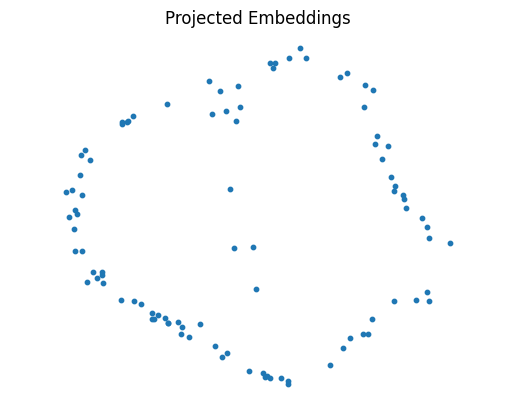

In [42]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

- 축소 후 질문 


In [43]:
query = "What is the main cause of climate change?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

began at the end of the last ice age, human societies f lourished, but the industrial era has seen unprecedented changes. modern observations modern scientific observations indicate a rapid increase in global temperatures, sea levels, and extreme weather events. the intergovernmental panel on climate change ( ipcc ) has documented these changes extensively. ice core samples, tree rings, and ocean sediments provide a historical record that scientists use to understand past climate conditions and predict future trends. the evidence overwhelmingly shows that recent changes are primarily driven by human activities, particularly the emission of greenhou se gases. chapter 2 : causes of climate change greenhouse gases the primary cause of recent climate change is the increase in greenhouse gases in the atmosphere. greenhouse gases, such as carbon dioxide ( co2 ), methane ( ch4 ), and nitrous

the effects of climate change are already being felt around the world and are projected to intensify 

In [44]:
query_embedding = embedding_function([query])[0] # 질문을 임베딩하여 벡터화
retrieved_embeddings = results['embeddings'][0] # 검색문서들의 임베딩 리스트를 가져옴 

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)
# 쿼리와 검색문서들에 대해 임베딩된 것을 투영함 


100%|██████████| 5/5 [00:00<00:00, 311.66it/s]


(7.014299726486206, 14.08623948097229, 0.9086940228939056, 7.100990897417068)

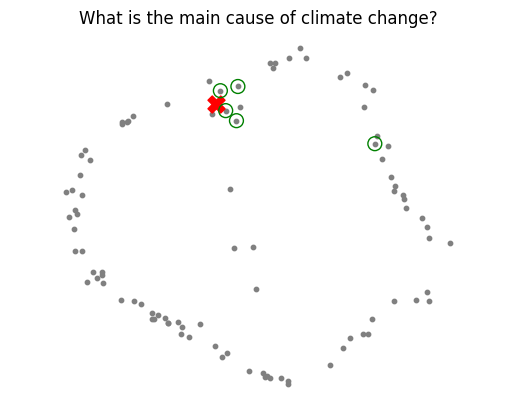

In [46]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
# 전체 데이터에 대한 임베딩 결과 
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
# 질문에 대한 임베딩 결과를 x로 표시 
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
# 검색 데이터에 대해 결과를 동그라미 표시 
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [48]:
query = "What are the impacts of climate change on the environment?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print('')
    print(document)


the effects of climate change are already being felt around the world and are projected to intensify in the coming decades. these effects include : rising temperatures global temperatures have risen by about 1. 2 degrees celsius ( 2. 2 degrees fahrenheit ) since the late 19th century. this warming is not uniform, with some regions experiencing more significant increases than others. heatwaves heatwaves are becoming more frequent and severe, posing risks to human health, agriculture, and infrastructure. cities are particularly vulnerable due to the " urban heat island " effect. heatwaves can lead to heat - related illnesses and exacerbate existing h ealth conditions. changing seasons climate change is altering the timing and length of seasons, affecting ecosystems and human activities. for example, spring is arriving earlier, and winters are becoming shorter and milder in many regions. this shift disrupts plant and animal life cycles a nd agricultural practices.

local communities are 

In [49]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:00<00:00, 349.57it/s]


(7.014299726486206, 14.08623948097229, 0.9086940228939056, 7.100990897417068)

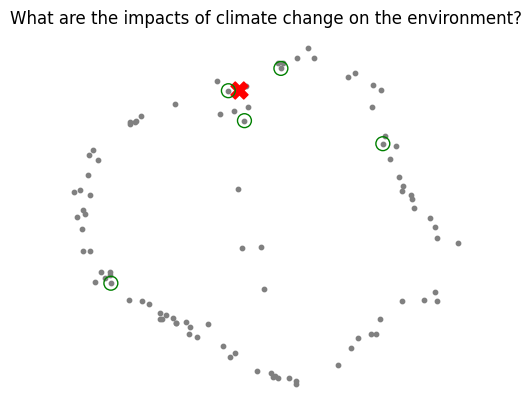

In [50]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

## 3. embedding adaptor 

In [56]:
import torch

In [59]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
import openai
import os
from dotenv import load_dotenv
from openai import OpenAI

# Load environment variables from a .env file
load_dotenv()

# Set the OpenAI API key environment variable
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
openai.api_key = os.getenv("OPENAI_API_KEY")
openai_client = OpenAI()


In [60]:
def generate_queries(model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert climate research assistant. You help users understand climate statements to better understand reader. "
            "Suggest 10 to 15 short questions that are important to ask when understanding climate change. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

- 새로운 질문 15가지 생성

In [61]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

1. What is the greenhouse effect and how does it contribute to climate change?
2. What evidence supports the idea that the Earth’s climate is changing?
3. How do human activities, such as burning fossil fuels, impact the climate?
4. What are the potential impacts of climate change on ecosystems and biodiversity?
5. How does climate change affect extreme weather events, such as hurricanes and droughts?
6. What is the role of the ocean in regulating the Earth’s climate?
7. How are scientists able to predict future climate scenarios?
8. What are some strategies we can implement to mitigate the effects of climate change?
9. How can individuals make a difference in combating climate change?
10. What are the differences between weather and climate?
11. How does deforestation contribute to climate change?
12. What is the relationship between climate change and sea-level rise?
13. What are the impacts of climate change on global food security?
14. How do changing climate patterns affect vulner

- chroma에서 질문에 대한 답변 생성 10가지씩

In [67]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [90]:
def evaluate_results(query, statement, model="gpt-3.5-turbo"):
    messages = [
    {
        "role": "system",
        "content": (
            "You are a helpful expert climate research assistant. "
            "You analyze documents and evaluate their relevance to a given query. "
            "For the given query, evaluate whether the following statement is relevant to answering the query. "
            "Respond strictly with the single word 'yes' or 'no'."
        )
    },
    {
        "role": "user",
        "content": f"Query: {query}\nStatement: {statement}"
    }
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    content = response.choices[0].message.content.strip().lower()
    if content == "yes":
        return 1
    return -1

In [91]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [92]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []
# 15가지 생서된 질문 
for q, query in enumerate(tqdm(generated_queries)):
    # 10가지 반환된 문서들 
    for d, document in enumerate(retrieved_documents[q]):
        # 질문 임베딩 , 질문에 대한 답변 임베딩, 답변에 대한 평가까지 
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|██████████| 15/15 [01:35<00:00,  6.37s/it]


In [95]:
len(adapter_labels)
# adapter_labels

150

- 쿼리, 문서, 평가 임베딩을 하나로 결합

In [96]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

In [110]:
adapter_query_embeddings.shape
adapter_doc_embeddings.shape
mat_size

384

In [97]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

1. 질문 임베딩을 변환하여 문서 임베딩
- 질문 임베딩을 어댑터 행렬 shape으로 변환하여 문서 임베딩과 공간에 맞게 변환시킴
- 변환된 임베딩으로 코사인 유사도를 계산했기 때문에 정확성이 올라감


In [99]:
def model(query_embedding, document_embedding, adaptor_matrix):
    # adaptor행렬로 질문 행렬을 변환하여 질문과 문서 간의 유사도를 반환 함 
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

# 실제 레이블과 계산된 유사도 간의 차이를 계산함 
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [100]:
# 384 차원으로 임베딩함 
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [101]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()
        

  0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/kmy_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:05<00:00, 16.74it/s]


In [102]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.587549090385437


In [103]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

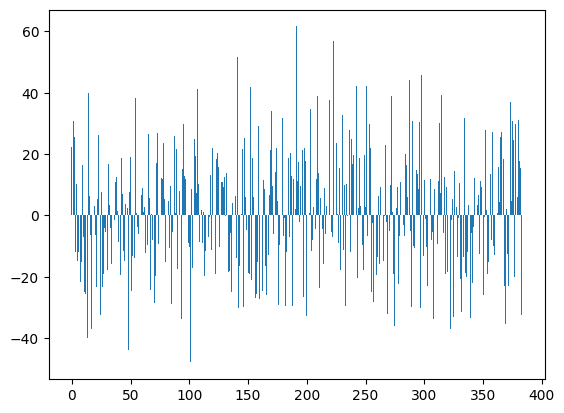

In [104]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()


In [105]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 15/15 [00:00<00:00, 115.10it/s]


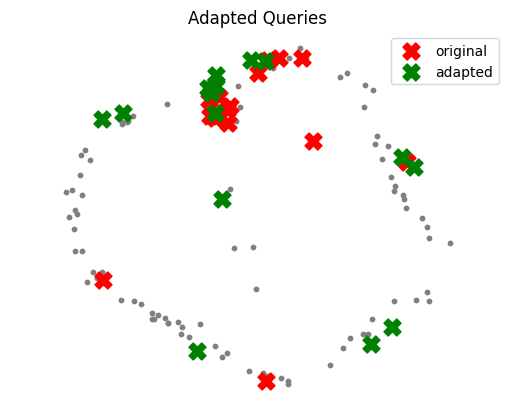

In [106]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()

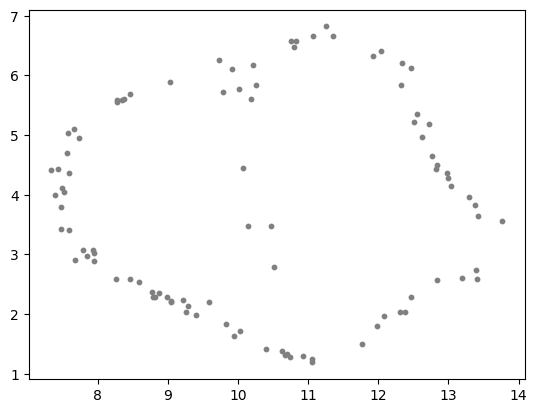

In [112]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')


- 결론: 초록색이 빨간색보다 문서 임베딩과 더 유사하게 변형되었기 때문에 임베딩 변환의 효과가 있었다고 할 수 있다.